---

_You are currently looking at **version 1.2** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-social-network-analysis/resources/yPcBs) course resource._

---

# Assignment 4

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle

---

## Part 1 - Random Graph Identification

For the first part of this assignment you will analyze randomly generated graphs and determine which algorithm created them.

In [2]:
P1_Graphs = pickle.load(open('A4_graphs','rb'))
P1_Graphs

<br>
`P1_Graphs` is a list containing 5 networkx graphs. Each of these graphs were generated by one of three possible algorithms:
* Preferential Attachment (`'PA'`)
* Small World with low probability of rewiring (`'SW_L'`)
* Small World with high probability of rewiring (`'SW_H'`)

Anaylze each of the 5 graphs and determine which of the three algorithms generated the graph.

*The `graph_identification` function should return a list of length 5 where each element in the list is either `'PA'`, `'SW_L'`, or `'SW_H'`.*

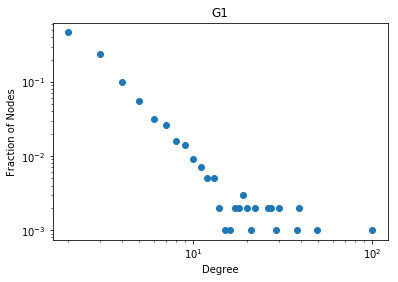

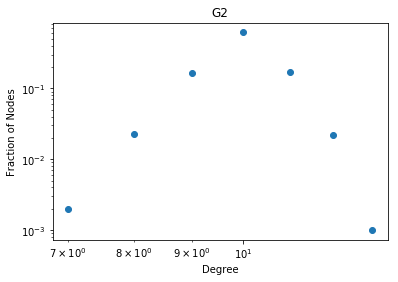

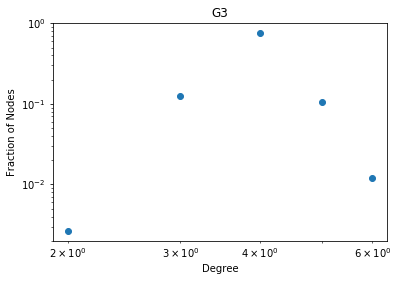

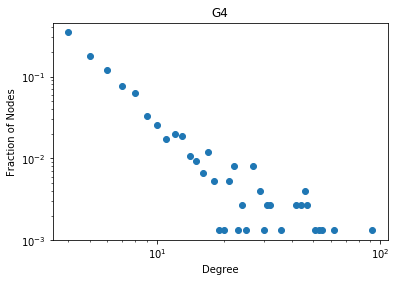

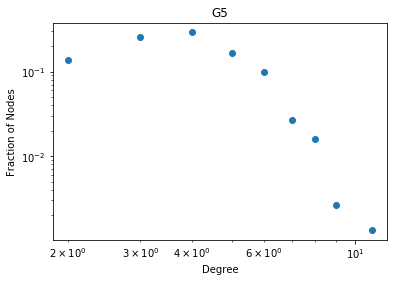

In [3]:
import matplotlib.pyplot as plt

for index ,G in enumerate(P1_Graphs):
    degrees = G.degree()
    degree_values = sorted(set(degrees.values()))
    histogram = [list(degrees.values()).count(i) / nx.number_of_nodes(G) for i in degree_values]

    graph_titles = ['G1','G2','G3','G4','G5']
    plt.title(graph_titles[index])
    plt.plot(degree_values , histogram , 'o')
    plt.xlabel('Degree')
    plt.ylabel('Fraction of Nodes')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

- ** From the figure we can say that `G1 & G4` are created by Preferential Attachment Model where the relation between the degree and Nodes on a log-log scale is represented by a `power law` which indicates that many nodes have small degree and a few nodes with very very large degree.**


- **On top of that, these 2 graphs consists of multiple nodes which point out that they represent a large real network.**

In [4]:
for index ,G in enumerate(P1_Graphs):
    print('\n Graph', index+1)
    print('CC: ',nx.average_clustering(G))
    print('shortest path :',nx.average_shortest_path_length(G))


 Graph 1
CC:  0.03167539146454044
shortest path : 4.099161161161161

 Graph 2
CC:  0.5642419635919628
shortest path : 5.089871871871872

 Graph 3
CC:  0.4018222222222227
shortest path : 9.378702269692925

 Graph 4
CC:  0.03780379975223251
shortest path : 3.1048046283934134

 Graph 5
CC:  0.0033037037037037037
shortest path : 5.0785509568313305


**After inspecting the clustering coefficient & the average shortest path length we came up with this conclution:**
- G2 has been created by small world (Low `P` rewiring probability) Model, because it has high CC.


- G3 has been created by small world (Low `P` rewiring probability) Model, because it has high CC & high AspL.


- G5 has been created by small world (High `P` rewiring probability) Model, because it has Low CC & Low AspL.

In [5]:
def graph_identification():
    Models = []
    for index ,G in enumerate(P1_Graphs):
        degrees = G.degree()
        degree_values = sorted(set(degrees.values()))
        histogram = [list(degrees.values()).count(i) /
                     nx.number_of_nodes(G) for i in degree_values]
        
        # clustering coefficient :
        cc = nx.average_clustering(G)
        # average shortest path length :
        AspL = nx.average_shortest_path_length(G)
        
        if len(histogram) > 10:
            Models.append('PA')
        elif cc < 0.1 :
            Models.append('SW_H')
        elif cc > 0.1 :
            Models.append('SW_L')
            
    return Models
graph_identification()

['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']

---

## Part 2 - Company Emails

For the second part of this assignment you will be workking with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagementSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagementSalary` indicates whether that person is receiving a management position salary.

In [6]:
G = nx.read_gpickle('email_prediction.txt')

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


In [7]:
G.is_directed()

False

In [8]:
G.nodes(data=True)[:6]

[(0, {'Department': 1, 'ManagementSalary': 0.0}),
 (1, {'Department': 1, 'ManagementSalary': nan}),
 (2, {'Department': 21, 'ManagementSalary': nan}),
 (3, {'Department': 21, 'ManagementSalary': 1.0}),
 (4, {'Department': 21, 'ManagementSalary': 1.0}),
 (5, {'Department': 25, 'ManagementSalary': nan})]

### Part 2A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a management position salary.

To accomplish this, you will need to create a matrix of node features using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a management salary for nodes where `ManagementSalary` is missing.



Your predictions will need to be given as the probability that the corresponding employee is receiving a management position salary.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 252 with the data being the probability of receiving management salary, and the index being the node id.

    Example:
    
        1       1.0
        2       0.0
        5       0.8
        8       1.0
            ...
        996     0.7
        1000    0.5
        1001    0.0
        Length: 252, dtype: float64

In [9]:
df = pd.DataFrame(index= G.nodes())
df['Department'] = pd.Series(nx.get_node_attributes(G,'Department'))
df['ManagementSalary'] = pd.Series(nx.get_node_attributes(G,'ManagementSalary'))
df['clustering'] = pd.Series(nx.clustering(G))
df['degree'] = pd.Series(G.degree())
df['closeness'] = pd.Series(nx.closeness_centrality(G, normalized=True))
df['betweeness'] = pd.Series(nx.betweenness_centrality(G, normalized=True))
df['pr'] = pd.Series(nx.pagerank(G))

# Train data

In [10]:
train_data = df.copy()

print(len(train_data))
train_data.head()

1005


,Department,ManagementSalary,clustering,degree,closeness,betweeness,pr
0,1,0.0,0.276423,44,0.421991,0.001124,0.001224
1,1,NaN,0.265306,52,0.422360,0.001195,0.001426
2,21,NaN,0.297803,95,0.461490,0.006570,0.002605
3,21,1.0,0.384910,71,0.441663,0.001654,0.001833
4,21,1.0,0.318691,96,0.462152,0.005547,0.002526


In [11]:
# inspect
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005 entries, 0 to 1004
Data columns (total 7 columns):
Department          1005 non-null int64
ManagementSalary    753 non-null float64
clustering          1005 non-null float64
degree              1005 non-null int64
closeness           1005 non-null float64
betweeness          1005 non-null float64
pr                  1005 non-null float64
dtypes: float64(5), int64(2)
memory usage: 62.8 KB


1. Drop row with NaN from train data.
2. Change the dtype of the columns to `str` & `int`.

In [12]:
# drop rows with NaN (Nan_people) from the train data.
Nan_people_index = train_data[train_data['ManagementSalary'].isnull()].index
train_data.drop(Nan_people_index , inplace=True)

print(len(train_data))
train_data.head()

753


,Department,ManagementSalary,clustering,degree,closeness,betweeness,pr
0,1,0.0,0.276423,44,0.421991,0.001124,0.001224
3,21,1.0,0.384910,71,0.441663,0.001654,0.001833
4,21,1.0,0.318691,96,0.462152,0.005547,0.002526
6,25,1.0,0.155183,115,0.475805,0.012387,0.003146
7,14,0.0,0.287785,72,0.420156,0.002818,0.002002


In [13]:
# convert dtype of `Department` to category & `ManagementSalary` to int
train_data['Department'] = train_data['Department'].astype('category')
train_data['ManagementSalary'] = train_data['ManagementSalary'].astype(int)
train_data.head()

,Department,ManagementSalary,clustering,degree,closeness,betweeness,pr
0,1,0,0.276423,44,0.421991,0.001124,0.001224
3,21,1,0.384910,71,0.441663,0.001654,0.001833
4,21,1,0.318691,96,0.462152,0.005547,0.002526
6,25,1,0.155183,115,0.475805,0.012387,0.003146
7,14,0,0.287785,72,0.420156,0.002818,0.002002


In [14]:
# check:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 753 entries, 0 to 1004
Data columns (total 7 columns):
Department          753 non-null category
ManagementSalary    753 non-null int64
clustering          753 non-null float64
degree              753 non-null int64
closeness           753 non-null float64
betweeness          753 non-null float64
pr                  753 non-null float64
dtypes: category(1), float64(4), int64(2)
memory usage: 43.5 KB


# Test data

In [15]:
test_data = df.copy()
test_data = test_data[test_data['ManagementSalary'].isnull()]

test_data['Department'] = test_data['Department'].astype('category')
test_data.drop('ManagementSalary' , axis=1 , inplace = True)

print('how many person to predict ',len(test_data))
test_data.head()

how many person to predict  252


,Department,clustering,degree,closeness,betweeness,pr
1,1,0.265306,52,0.422360,0.001195,0.001426
2,21,0.297803,95,0.461490,0.006570,0.002605
5,25,0.107002,171,0.501484,0.030995,0.004914
8,14,0.447059,37,0.413151,0.000557,0.001059
14,4,0.215784,80,0.442068,0.003726,0.002166


# preparing data to the ML algorithm and applying it.

In [16]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [17]:
choosen_feature = ['Department','clustering','degree', 'closeness', 'betweeness', 'pr']
final_train = train_data[choosen_feature]
final_test =  test_data[choosen_feature]
target_value = train_data['ManagementSalary']

In [18]:
X = final_train
y = target_value

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0)

In [19]:
# train the model
GBclf = GradientBoostingClassifier(random_state=0).fit(X_train,y_train)

In [20]:
# get y_scores
yscores_GBclf = GBclf.decision_function(X_test)

# get false positive rate , True positive rate.
fpr_GBclf, tpr_GBclf, _ = roc_curve(y_test ,yscores_GBclf)
# get the area under curve.
roc_auc_GBclf = auc(fpr_GBclf , tpr_GBclf)
# get the accuracy.
accuracy_GBclf = GBclf.score(X_test, y_test)

print("accuracy = {:.4f}   AUC = {:.4f}".format(accuracy_GBclf,  roc_auc_GBclf))

accuracy = 0.9048   AUC = 0.9505


In [21]:
y_probability = GBclf.predict_proba(final_test)[:,1]
final_test['ManagementSalary'] = y_probability
final_test['ManagementSalary'].head()

1     0.008000
2     0.986760
5     0.988358
8     0.258055
14    0.024979
Name: ManagementSalary, dtype: float64

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

def salary_predictions():
    df = pd.DataFrame(index= G.nodes())
    df['Department'] = pd.Series(nx.get_node_attributes(G,'Department'))
    df['ManagementSalary'] = pd.Series(nx.get_node_attributes(G,'ManagementSalary'))
    df['clustering'] = pd.Series(nx.clustering(G))
    df['degree'] = pd.Series(G.degree())
    df['closeness'] = pd.Series(nx.closeness_centrality(G, normalized=True))
    df['betweeness'] = pd.Series(nx.betweenness_centrality(G, normalized=True))
    df['pr'] = pd.Series(nx.pagerank(G))
    
    train_data = df.copy()
    # drop rows with NaN (Nan_people) from the train data.
    Nan_people_index = train_data[train_data['ManagementSalary'].isnull()].index
    train_data.drop(Nan_people_index , inplace=True)
    # convert dtype of `Department` to category & `ManagementSalary` to int
    train_data['Department'] = train_data['Department'].astype('category')
    train_data['ManagementSalary'] = train_data['ManagementSalary'].astype(int)
    
    
    test_data = df.copy()
    test_data = test_data[test_data['ManagementSalary'].isnull()]
    test_data['Department'] = test_data['Department'].astype('category')
    test_data.drop('ManagementSalary' , axis=1 , inplace = True)
    
    choosen_feature = ['Department','clustering','degree', 'closeness', 'betweeness', 'pr']
    final_train = train_data[choosen_feature]
    final_test =  test_data[choosen_feature]
    target_value = train_data['ManagementSalary']
    
    X = final_train
    y = target_value
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0)
    # train the model
    GBclf = GradientBoostingClassifier(random_state=0).fit(X_train,y_train)
    
    # get y_scores
    yscores_GBclf = GBclf.decision_function(X_test)
    # get false positive rate , True positive rate.
    fpr_GBclf, tpr_GBclf, _ = roc_curve(y_test ,yscores_GBclf)
    # get the area under curve.
    roc_auc_GBclf = auc(fpr_GBclf , tpr_GBclf)
    # get the accuracy.
    accuracy_GBclf = GBclf.score(X_test, y_test)
    
    y_probability = GBclf.predict_proba(final_test)[:,1]
    final_test['ManagementSalary'] = y_probability

    return final_test['ManagementSalary']

salary_predictions().head()

1     0.008000
2     0.986760
5     0.988358
8     0.258055
14    0.024979
Name: ManagementSalary, dtype: float64

### Part 2B - New Connections Prediction

For the last part of this assignment, you will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [23]:
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


# How to merge by all means :
https://www.statology.org/pandas-merge-on-index/

Using network `G` and `future_connections`, identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, you will need to create a matrix of features for the edges found in `future_connections` using networkx, train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data, and predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



Your predictions will need to be given as the probability of the corresponding edge being a future connection.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 122112 with the data being the probability of the edge being a future connection, and the index being the edge as represented by a tuple of nodes.

    Example:
    
        (107, 348)    0.35
        (542, 751)    0.40
        (20, 426)     0.55
        (50, 989)     0.35
                  ...
        (939, 940)    0.15
        (555, 905)    0.35
        (75, 101)     0.65
        Length: 122112, dtype: float64

In [24]:
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_conn = future_connections

future_conn['preferential attachment'] = [i[2] for i in
                         nx.preferential_attachment(G,future_conn.index)]

future_conn['preferential attachment'] = [i[2] for i in
                         nx.preferential_attachment(G,future_conn.index)]

future_conn['Common Neighbors']= future_conn.index.map(lambda edge:
                        len(list(nx.common_neighbors(G,edge[0],edge[1]))))

future_conn['Jaccard Coefficient'] = [i[2] for i in
                          nx.jaccard_coefficient(G,future_conn.index)]

future_conn['Resource Allocation'] = [i[2] for i in
                        nx.resource_allocation_index(G,future_conn.index)]

future_conn['Adamic-Adar Index'] = [i[2] for i in
                        nx.resource_allocation_index(G,future_conn.index)]

print(len(future_conn))
future_conn.head()

488446


,Future Connection,preferential attachment,Common Neighbors,Jaccard Coefficient,Resource Allocation,Adamic-Adar Index
"(6, 840)",0.0,2070,9,0.073770,0.136721,0.136721
"(4, 197)",0.0,3552,2,0.015504,0.008437,0.008437
"(620, 979)",0.0,28,0,0.000000,0.000000,0.000000
"(519, 872)",0.0,299,2,0.060606,0.039726,0.039726
"(382, 423)",0.0,205,0,0.000000,0.000000,0.000000


## Train data

In [25]:
train_data = future_conn.copy()

# drop rows with NaN (Nan_edges) from the train data the ones to predict.
Nan_edges_index = train_data[train_data['Future Connection'].isnull()].index
train_data.drop(Nan_edges_index , inplace=True)

print(len(train_data))
train_data.head()

366334


,Future Connection,preferential attachment,Common Neighbors,Jaccard Coefficient,Resource Allocation,Adamic-Adar Index
"(6, 840)",0.0,2070,9,0.073770,0.136721,0.136721
"(4, 197)",0.0,3552,2,0.015504,0.008437,0.008437
"(620, 979)",0.0,28,0,0.000000,0.000000,0.000000
"(519, 872)",0.0,299,2,0.060606,0.039726,0.039726
"(382, 423)",0.0,205,0,0.000000,0.000000,0.000000


## Test data.

In [26]:
test_data = future_conn.copy()

test_data = test_data[test_data['Future Connection'].isnull()]
test_data.drop('Future Connection' , axis=1 , inplace = True)

print(len(test_data))
test_data.head()

122112


,preferential attachment,Common Neighbors,Jaccard Coefficient,Resource Allocation,Adamic-Adar Index
"(107, 348)",884,2,0.009009,0.025562,0.025562
"(542, 751)",126,0,0.000000,0.000000,0.000000
"(20, 426)",4440,10,0.081967,0.082016,0.082016
"(50, 989)",68,0,0.000000,0.000000,0.000000
"(942, 986)",6,0,0.000000,0.000000,0.000000


# prepare for ML model.

In [33]:
choosen_feature = ['preferential attachment','Common Neighbors','Jaccard Coefficient','Resource Allocation','Adamic-Adar Index']
final_train = train_data[choosen_feature]
final_test =  test_data[choosen_feature]
target_value = train_data['Future Connection']

In [34]:
X = final_train
y = target_value

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0)
# train the Model
GBclf = GradientBoostingClassifier(random_state = 0).fit(X_train,y_train)

In [35]:
# get y_scores
yscores_GBclf = GBclf.decision_function(X_test)

# get false positive rate , True positive rate.
fpr_GBclf, tpr_GBclf, _ = roc_curve(y_test ,yscores_GBclf)
# get the area under curve.
roc_auc_GBclf = auc(fpr_GBclf , tpr_GBclf)
# get the accuracy.
accuracy_GBclf = GBclf.score(X_test, y_test)

print("accuracy = {:.4f}   AUC = {:.4f}".format(accuracy_GBclf,  roc_auc_GBclf))

accuracy = 0.9602   AUC = 0.9102


In [36]:
y_probability = GBclf.predict_proba(final_test)[:,1]
final_test['compliance'] = y_probability
final_test['compliance'].head()

(107, 348)    0.028061
(542, 751)    0.013133
(20, 426)     0.505561
(50, 989)     0.013133
(942, 986)    0.013760
Name: compliance, dtype: float64

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

def new_connections_predictions():
    future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
    future_conn = future_connections

    future_conn['preferential attachment'] = [i[2] for i in
                             nx.preferential_attachment(G,future_conn.index)]

    future_conn['preferential attachment'] = [i[2] for i in
                             nx.preferential_attachment(G,future_conn.index)]

    future_conn['Common Neighbors']= future_conn.index.map(lambda edge:
                            len(list(nx.common_neighbors(G,edge[0],edge[1]))))

    future_conn['Jaccard Coefficient'] = [i[2] for i in
                              nx.jaccard_coefficient(G,future_conn.index)]

    future_conn['Resource Allocation'] = [i[2] for i in
                            nx.resource_allocation_index(G,future_conn.index)]

    future_conn['Adamic-Adar Index'] = [i[2] for i in
                            nx.resource_allocation_index(G,future_conn.index)]

    
    train_data = future_conn.copy()
    # drop rows with NaN (Nan_edges) from the train data the ones to predict.
    Nan_edges_index = train_data[train_data['Future Connection'].isnull()].index
    train_data.drop(Nan_edges_index , inplace=True)
    
    test_data = future_conn.copy()
    test_data = test_data[test_data['Future Connection'].isnull()]
    test_data.drop('Future Connection' , axis=1 , inplace = True)

    choosen_feature = ['preferential attachment','Common Neighbors','Jaccard Coefficient','Resource Allocation','Adamic-Adar Index']
    final_train = train_data[choosen_feature]
    final_test =  test_data[choosen_feature]
    target_value = train_data['Future Connection']
    
    X = final_train
    y = target_value
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0)
    # train the Model
    GBclf = GradientBoostingClassifier(random_state = 0).fit(X_train,y_train)
    
    # get y_scores
    yscores_GBclf = GBclf.decision_function(X_test)
    # get false positive rate , True positive rate.
    fpr_GBclf, tpr_GBclf, _ = roc_curve(y_test ,yscores_GBclf)
    # get the area under curve.
    roc_auc_GBclf = auc(fpr_GBclf , tpr_GBclf)
    # get the accuracy.
    accuracy_GBclf = GBclf.score(X_test, y_test)
    
    y_probability = GBclf.predict_proba(final_test)[:,1]
    final_test['compliance'] = y_probability
    
    return final_test['compliance']

new_connections_predictions().head()

(107, 348)    0.028061
(542, 751)    0.013133
(20, 426)     0.505561
(50, 989)     0.013133
(942, 986)    0.013760
Name: compliance, dtype: float64